Augment the literature data

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [3]:
# Visualize ptl1
data1 = data[data['ptl_idx']==1]
# X = np.array([data1['dt1'], data1['dw_mean']]).reshape((-1,2))
X = np.array(data1['dt1']).reshape(-1,1)
y = np.array(data1['dw_mean']).reshape(-1,1)

In [4]:
X.shape

(45, 1)

[-110, 100, -50, 120]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


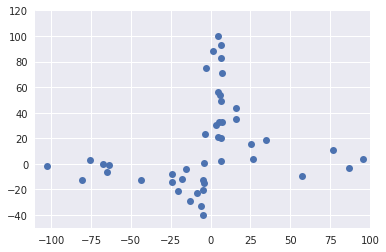

In [5]:
plt.plot(data1['dt1'], data1['dw_mean'], 'o')
plt.axis([-110, 100, -50, 120])

In [6]:
list(data.columns)

['ptl_idx',
 'pre_spk_num',
 'pre_spk_freq',
 'post_spk_num',
 'post_spk_freq',
 'ptl_occ',
 'ptl_freq',
 'dt1',
 'dt2',
 'dt3',
 'dw_mean',
 'dw_ste',
 'train_len']

In [7]:
# Generate dt1
# Insert values for STDP
dt = np.arange(-100,100,2)
data1_gen = pd.DataFrame(data=None, columns=list(data.columns))
for i in range(len(dt)):
    new_try1 = data1.iloc[0]
    new_try1['dt1'] = dt[i]
    data1_gen = data1_gen.append(new_try1, ignore_index=True)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-110, 100, -50, 120]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


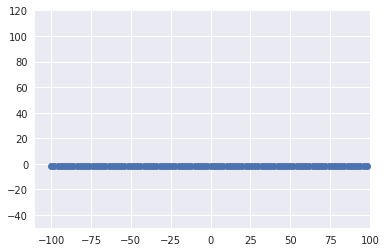

In [8]:
plt.plot(data1_gen['dt1'], data1_gen['dw_mean'], 'o')
plt.axis([-110, 100, -50, 120])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


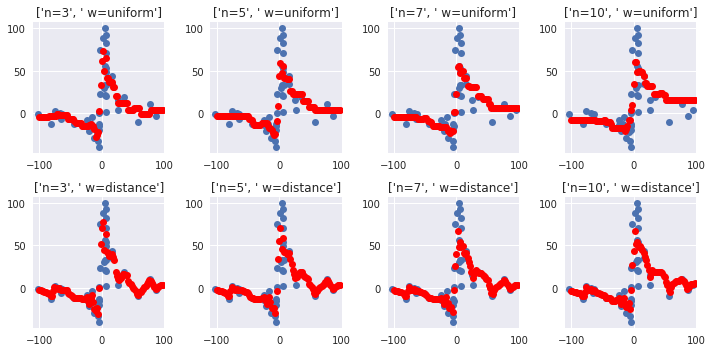

In [9]:
# Use K nearest neigbors to estimate the mean value of a given dt1
from sklearn.neighbors import KNeighborsRegressor

# Search through the parameter for the one gives the minimum reconstruction error
n_neighbors = [3,5,7,10]
weights = ['uniform', 'distance']

figure, ax = plt.subplots(2,4)
figure.set_figheight(5)
figure.set_figwidth(10)

for j in range(len(weights)):
    for i in range(len(n_neighbors)):
        
        Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors[i], weights=weights[j])
        Kn_reg.fit(X,y)
        y_pred = Kn_reg.predict(np.array(data1_gen['dt1']).reshape(-1,1))
        
        # Calculate mean squared error
        
        ax[j,i].plot(data1['dt1'], data1['dw_mean'], 'o')
        ax[j,i].plot(data1_gen['dt1'], y_pred, 'ro')
        ax[j,i].set_xlim([-110,100])
        ax[j,i].set_title(['n=%d'%(n_neighbors[i]), ' w=%s'%(weights[j])])
plt.tight_layout()

In [10]:
# Choose one parameter and generate the prediction
n_neighbors = 3
weights = 'uniform'

Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
Kn_reg.fit(X,y)
y_pred = Kn_reg.predict(np.array(data1_gen['dt1']).reshape(-1,1))

In [11]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


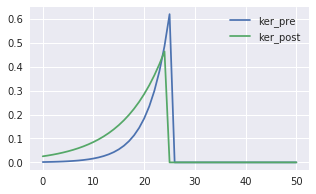

In [12]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen()
ker_test.trip_model_ker(para)
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))

In [13]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data1_gen, ptl_list=ptl_list, targets=y_pred, spk_len=spk_len, kernel=ker_test, aug_times=[20])

In [14]:
spk_pairs.shape

(2000, 30000, 2)

In [15]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [16]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/PairNet_ptl1_real_aug'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [17]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

In [18]:
# w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
# w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
# fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
# plt.plot(w_pre,  label='ker_pre_trained')
# plt.plot(w_post,  label='ker_post_trained')
# plt.legend()
# fc_w[:2]

In [19]:
# # Learn the kernel from random initialization
# learning_rate = 0.001
# iterations = 5
# min_error = -1
# for i in range(iterations):
#     toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
#     learning_rate = learning_rate/3

array([ 2.21894383,  1.45111072], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


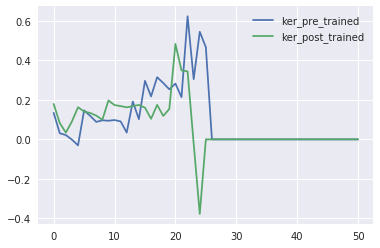

In [20]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.legend()
fc_w[:2]

In [21]:
# Compare the target and prediction

In [22]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_scale = fc_w

In [23]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(df=data1_gen, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[20])

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


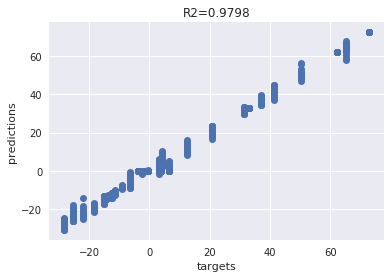

In [32]:
R2 = 1 - np.sum(np.square(predictions - targets))/np.sum(np.square(targets - np.mean(targets)))
plt.plot(targets, predictions, 'o')
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title('R2=%.4f'%(R2))

In [44]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, real_stdp_prediction = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[1])

In [45]:
real_stdp_prediction.shape

(45, 1)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


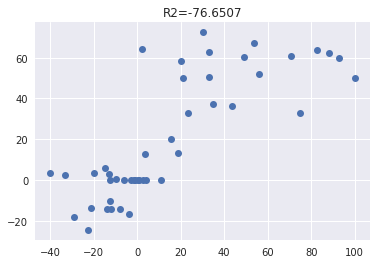

In [46]:
real_stdp_targets = np.array(data1['dw_mean'])
R2 = 1 - np.sum(np.square(real_stdp_prediction - real_stdp_targets))/np.sum(np.square(real_stdp_targets - np.mean(real_stdp_targets)))
plt.plot(real_stdp_targets, real_stdp_prediction, 'o')
plt.title('R2=%.4f'%(R2))

In [47]:
np.sum(np.square(real_stdp_prediction - real_stdp_targets))

4369960.9819384115

In [48]:
np.sum(np.square(real_stdp_targets - np.mean(real_stdp_targets)))

56277.165249208199